Select a model for demand estimation

In [1]:
#install.packages("rlang")
#install.packages("tidymodels")
#install.packages("tidyverse")
#install.packages("poissonreg")
#install.packages("ranger")
#install.packages("xgboost")
#install.packages("vip")

library(tidymodels)
library(tidyverse)
library(stringr)
library(poissonreg)
library(ranger)
library(xgboost)
library(vip)

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5      ✔ recipes      1.0.10
✔ dials        1.2.1      ✔ rsample      1.2.1 
✔ dplyr        1.1.4      ✔ tibble       3.2.1 
✔ ggplot2      3.5.0      ✔ tidyr        1.3.1 
✔ infer        1.0.7      ✔ tune         1.2.0 
✔ modeldata    1.3.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.1      ✔ workflowsets 1.1.0 
✔ purrr        1.0.2      ✔ yardstick    1.3.1 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ lubridate 1.9.3     ✔ stringr   1.5.0
── Conflicts ────────────────────────────────────────── tidyverse_

Read in data on weather, time, and bike rental data for Seoul. Note that this is an exercise. In practice, models should either incorporate local data, or estimate a model that accounts for a distribution of city characteristics.

In [2]:
dataset_url <- "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/datasets/seoul_bike_sharing_converted_normalized.csv"

bike_sharing_df <- read_csv(dataset_url)
bike_sharing_df <- select(bike_sharing_df, !"FUNCTIONING_DAY" & !"DEW_POINT_TEMPERATURE" & 
                          !"SOLAR_RADIATION" & !"SNOWFALL" & !"RAINFALL" & !"HOLIDAY" & !"NO_HOLIDAY")
glimpse(bike_sharing_df)


Rows: 8465 Columns: 41
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): DATE, FUNCTIONING_DAY
dbl (39): RENTED_BIKE_COUNT, TEMPERATURE, HUMIDITY, WIND_SPEED, VISIBILITY, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 8,465
Columns: 34
$ DATE              <chr> "01/12/2017", "01/12/2017", "01/12/2017", "01/12/201…
$ RENTED_BIKE_COUNT <dbl> 254, 204, 173, 107, 78, 100, 181, 460, 930, 490, 339…
$ TEMPERATURE       <dbl> 0.2202797, 0.2150350, 0.2062937, 0.2027972, 0.206293…
$ HUMIDITY          <dbl> 0.3775510, 0.3877551, 0.3979592, 0.4081633, 0.367346…
$ WIND_SPEED        <dbl> 0.29729730, 0.10810811, 0.13513514, 0.12162162, 0.31…
$ VISIBILITY        <dbl> 1.0000000, 1.0000000, 1.0000000, 1.0000000, 1.000000…
$ `0`               <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ `1`               <dbl> 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ `10`              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0…
$ `11`              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0…
$ `12`              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0…
$ `13`              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0…
$ `14`          

Reserve 20% of observations for testing purposes.

In [3]:
set.seed(4872)
data_split <- initial_split(bike_sharing_df, prop=0.8)
train_data <- training(data_split)
test_data <- testing(data_split)

Standardize formula in recipe:

In [4]:
bike_demand_recipe <- 
  recipe(RENTED_BIKE_COUNT ~ ., data=train_data) %>%
  update_role("DATE", new_role="ID")
  

Set model specifications appropriate for count data:

In [5]:
#Interpretable models
linear_mod <- linear_reg(penalty=tune(), mixture=1, engine="glmnet")

count_mod <- poisson_reg(mode="regression", penalty=tune(), mixture=1, engine="glmnet")

#Noninterpretable models
rand_forest_mod <- rand_forest(mode="regression", trees=1000,
                              min_n=tune())

boost_mod <- boost_tree(mode="regression", engine="xgboost", 
                        trees=1000, stop_iter=20,
                       min_n=tune(), learn_rate=tune())


Workflow objects:

In [6]:
base_wf <- workflow() %>% add_recipe(bike_demand_recipe)

linear_wf <- base_wf %>% add_model(linear_mod)

count_wf <- base_wf %>% add_model(count_mod)

forest_wf <- base_wf %>% add_model(rand_forest_mod)

boost_wf <- base_wf %>% add_model(boost_mod)

Tuning grids for hyperparameters:

In [8]:
cv_folds <- vfold_cv(train_data, v = 10)

lasso_grid <- grid_regular(levels = 50,
  penalty(range = c(-3, 0.3)))

forest_grid <- grid_regular(levels=5,
                            min_n())

boost_grid <- grid_regular(levels=3,
                           min_n(),
                           learn_rate())

For each candidate model, tune hyperparameters using crossvalidation, test fit of best root mean squared error model on reserved testing data, and refit on full dataset. Recommend tuning boosting model separately, as it takes substantially longer to fit.

In [9]:
linear_tune <- linear_wf %>% tune_grid(resamples=cv_folds, grid=lasso_grid)
count_tune <- count_wf %>% tune_grid(resamples=cv_folds, grid=lasso_grid)

best_linear <- linear_tune %>% select_best(metric="rmse")
best_count <- count_tune %>% select_best(metric="rmse")

final_linear <- linear_wf %>% finalize_workflow(best_linear)
final_count <- count_wf %>% finalize_workflow(best_count)

In [10]:
forest_tune <- forest_wf %>% tune_grid(resamples=cv_folds, grid=forest_grid)
best_forest <- forest_tune %>% select_best(metric="rmse")
final_forest <- forest_wf %>% finalize_workflow(best_forest)

In [11]:
linear_fit <- final_linear %>% last_fit(data_split)
count_fit <- final_count %>% last_fit(data_split)
forest_fit <- final_forest %>% last_fit(data_split)

In [15]:
boost_tune <- boost_wf %>% tune_grid(resamples=cv_folds, grid=boost_grid)
best_boost <- boost_tune %>% select_best(metric="rmse")
final_boost <- boost_wf %>% finalize_workflow(best_boost)

In [16]:
boost_fit <- final_boost %>% last_fit(data_split)

In [12]:
linear_fit %>% collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,384.1508890,Preprocessor1_Model1
rsq,standard,0.6438476,Preprocessor1_Model1


In [13]:
count_fit %>% collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,350.8023259,Preprocessor1_Model1
rsq,standard,0.7026592,Preprocessor1_Model1


In [14]:
forest_fit %>% collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,278.6373747,Preprocessor1_Model1
rsq,standard,0.8219941,Preprocessor1_Model1


In [17]:
boost_fit %>% collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,264.1593610,Preprocessor1_Model1
rsq,standard,0.8318869,Preprocessor1_Model1


Save the champion model for use in dashboard.

In [18]:
champ <- extract_workflow(boost_fit)

In [19]:
saveRDS(champ, "champion_model.R")

In [67]:
champ

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
##### xgb.Booster
raw: 2 Mb 
call:
  xgboost::xgb.train(params = list(eta = 0.1, max_depth = 6, gamma = 0, 
    colsample_bytree = 1, colsample_bynode = 1, min_child_weight = 30L, 
    subsample = 1), data = x$data, nrounds = 1000, watchlist = x$watchlist, 
    verbose = 0, early_stopping_rounds = 20, nthread = 1, objective = "reg:squarederror")
params (as set within xgb.train):
  eta = "0.1", max_depth = "6", gamma = "0", colsample_bytree = "1", colsample_bynode = "1", min_child_weight = "30", subsample = "1", nthread = "1", objective = "reg:squarederror", validate_parameters = "TRUE"
xgb.attributes:
  best_iteration, best_msg, best_ntreelimit, best_score, niter
callbacks:
  cb.evaluation.

In [25]:
champ <- readRDS("./champion_model.R")
forecasts <- champ %>% predict(train_data)

In [26]:
glimpse(forecasts)

Rows: 6,772
Columns: 1
$ .pred <dbl> 2361.81519, 914.30731, 1621.66321, 91.48222, 603.95331, 388.4130…


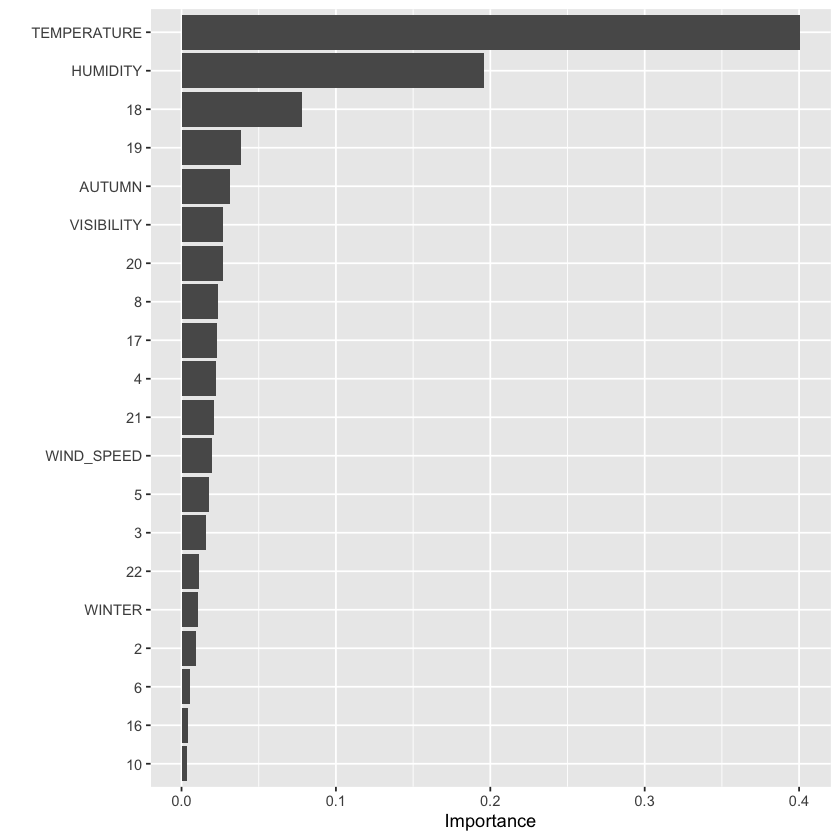

In [24]:
champ %>% vip(num_features=20)

##### 

In [27]:
summary(bike_sharing_df)

     DATE           RENTED_BIKE_COUNT  TEMPERATURE        HUMIDITY     
 Length:8465        Min.   :   2.0    Min.   :0.0000   Min.   :0.0000  
 Class :character   1st Qu.: 214.0    1st Qu.:0.3636   1st Qu.:0.4286  
 Mode  :character   Median : 542.0    Median :0.5472   Median :0.5816  
                    Mean   : 729.2    Mean   :0.5345   Mean   :0.5933  
                    3rd Qu.:1084.0    3rd Qu.:0.7080   3rd Qu.:0.7551  
                    Max.   :3556.0    Max.   :1.0000   Max.   :1.0000  
   WIND_SPEED       VISIBILITY           0                 1          
 Min.   :0.0000   Min.   :0.0000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.1216   1st Qu.:0.4602   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :0.2027   Median :0.8429   Median :0.00000   Median :0.00000  
 Mean   :0.2332   Mean   :0.7131   Mean   :0.04158   Mean   :0.04158  
 3rd Qu.:0.3108   3rd Qu.:1.0000   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.00000   Max.   :1.00000  